In [79]:
import os
from glob import glob
from tkinter import image_types

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split


In [76]:
DATA_PATH = "dataset"

# Find all .jpg files in subdirectories
all_files = glob(os.path.join(DATA_PATH, "*", "*.jpg"))

def get_metadata(file_path):
    # Class name is the folder where the file is located
    class_name = os.path.basename(os.path.dirname(file_path))

    # Determine image type based on filename convention
    file_name = os.path.basename(file_path).lower()
    if "stamp" in file_name:
        image_type = "Stamp (Photo)"
    elif "digit" in file_name:
        image_type = "Hand-Drawn (Scanned/Digitalized)"
    elif "drawn" in file_name:
        image_type = "Hand-Drawn (Photo)"
    else:
        image_type = "Unknown"

    return class_name, image_type

# Create DataFrame
data = [get_metadata(i) + (i,) for i in all_files]
data_df = pd.DataFrame(data, columns=["class_name", "image_type", "filepath"])

print(f"Number of files found: {len(data_df)}")
print(f"Number of unique classes: {data_df['class_name'].unique()}")

if len(data_df) == 0:
    print("Check the file path")
else:
    print("Sample records")
    print(data_df.head())


Number of files found: 431
Number of unique classes: ['anchor' 'balloon' 'bicycle' 'envelope' 'paper_boat' 'peace_symbol'
 'smiley' 'speech_bubble' 'spiral' 'thumb']
Sample records
  class_name                        image_type                    filepath
0     anchor  Hand-Drawn (Scanned/Digitalized)  dataset\anchor\digit01.jpg
1     anchor  Hand-Drawn (Scanned/Digitalized)  dataset\anchor\digit02.jpg
2     anchor  Hand-Drawn (Scanned/Digitalized)  dataset\anchor\digit03.jpg
3     anchor  Hand-Drawn (Scanned/Digitalized)  dataset\anchor\digit04.jpg
4     anchor  Hand-Drawn (Scanned/Digitalized)  dataset\anchor\digit05.jpg


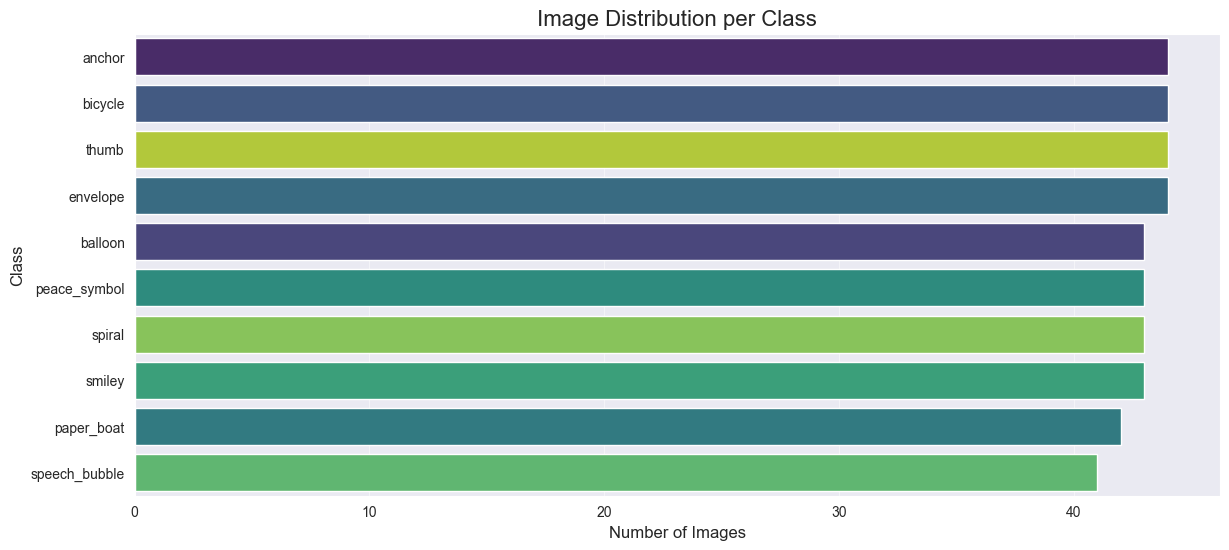

Largest class has: 44 samples
Smallest class has: 41 samples
Conclusion - Dataset is well balanced in terms of samples per class


In [65]:
plt.figure(figsize=(14, 6))
sns.countplot(y="class_name", data=data_df, order=data_df["class_name"].value_counts().index, palette="viridis", hue="class_name", legend=False)
plt.title("Image Distribution per Class", fontsize=16)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Class", fontsize=12)
plt.grid(axis="x", alpha=0.5)
plt.show()

# Check for class imbalance
class_counts = data_df["class_name"].value_counts()
min_count = class_counts.min()
max_count = class_counts.max()

print(f"Largest class has: {max_count} samples")
print(f"Smallest class has: {min_count} samples")

# Conclusion 1: Balance analysis

if max_count / min_count > 1.2:
    print(f"Potential issue -> Slight class imbalance detected (ratio: {max_count / min_count:.2f}). Weighted training may be required.")
else:
    print("Conclusion - Dataset is well balanced in terms of samples per class")


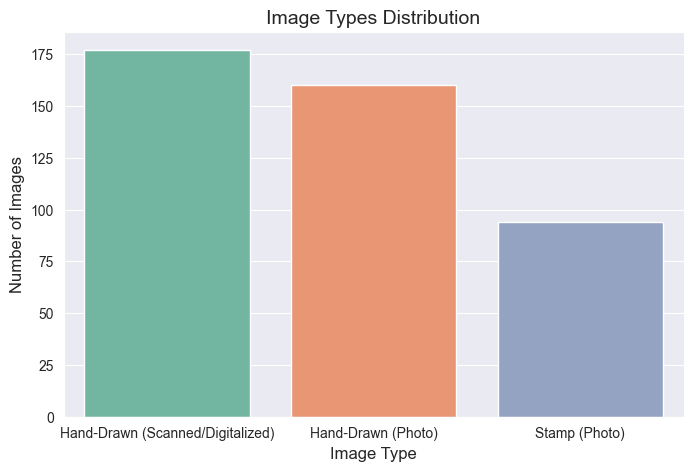

In [67]:
plt.figure(figsize=(8,5))
sns.countplot(x='image_type', data=data_df, palette="Set2", hue="image_type", legend=False)
plt.title("Image Types Distribution", fontsize=14)
plt.xlabel("Image Type", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.show()

In [68]:
# Analiza 100 losowych próbek pod kątem rozmiaru i trybu koloru
sample_files = data_df["filepath"].sample(min(200, len(data_df)), random_state=42)
sizes = []
modes = []

for f in sample_files:
    try:
        img = Image.open(f)
        sizes.append(img.size)
        modes.append(img.mode)
    except Exception as e:
        print(f"Error loading file {f}: {e}")

widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]

print("\nImage Size Statistics:")
print(f"Unique sizes: {set(sizes) if len(set(sizes)) < 10 else 'Many different sizes'}")
print(f"Median width: {np.median(widths)}, median height: {np.median(heights)}")

mode_counts = pd.Series(modes).value_counts()
print("\nColor Depth Statistics (PIL Mode):")
print(mode_counts)

if len(set(sizes)) > 1:
    print("\nEDA CONCLUSION: Image sizes are heterogeneous. Unification required (`Resize`) in Stage 2.")
else:
    print("\nOK")
if len(mode_counts) > 1:
    print("EDA CONCLUSION: Mixed color modes detected (e.g., RGB and Grayscale). Conversion to uniform format (e.g., RGB) required in Stage 2.")
else:
    print("\nOK")


Image Size Statistics:
Unique sizes: {(160, 130)}
Median width: 160.0, median height: 130.0

Color Depth Statistics (PIL Mode):
L    200
Name: count, dtype: int64

OK

OK


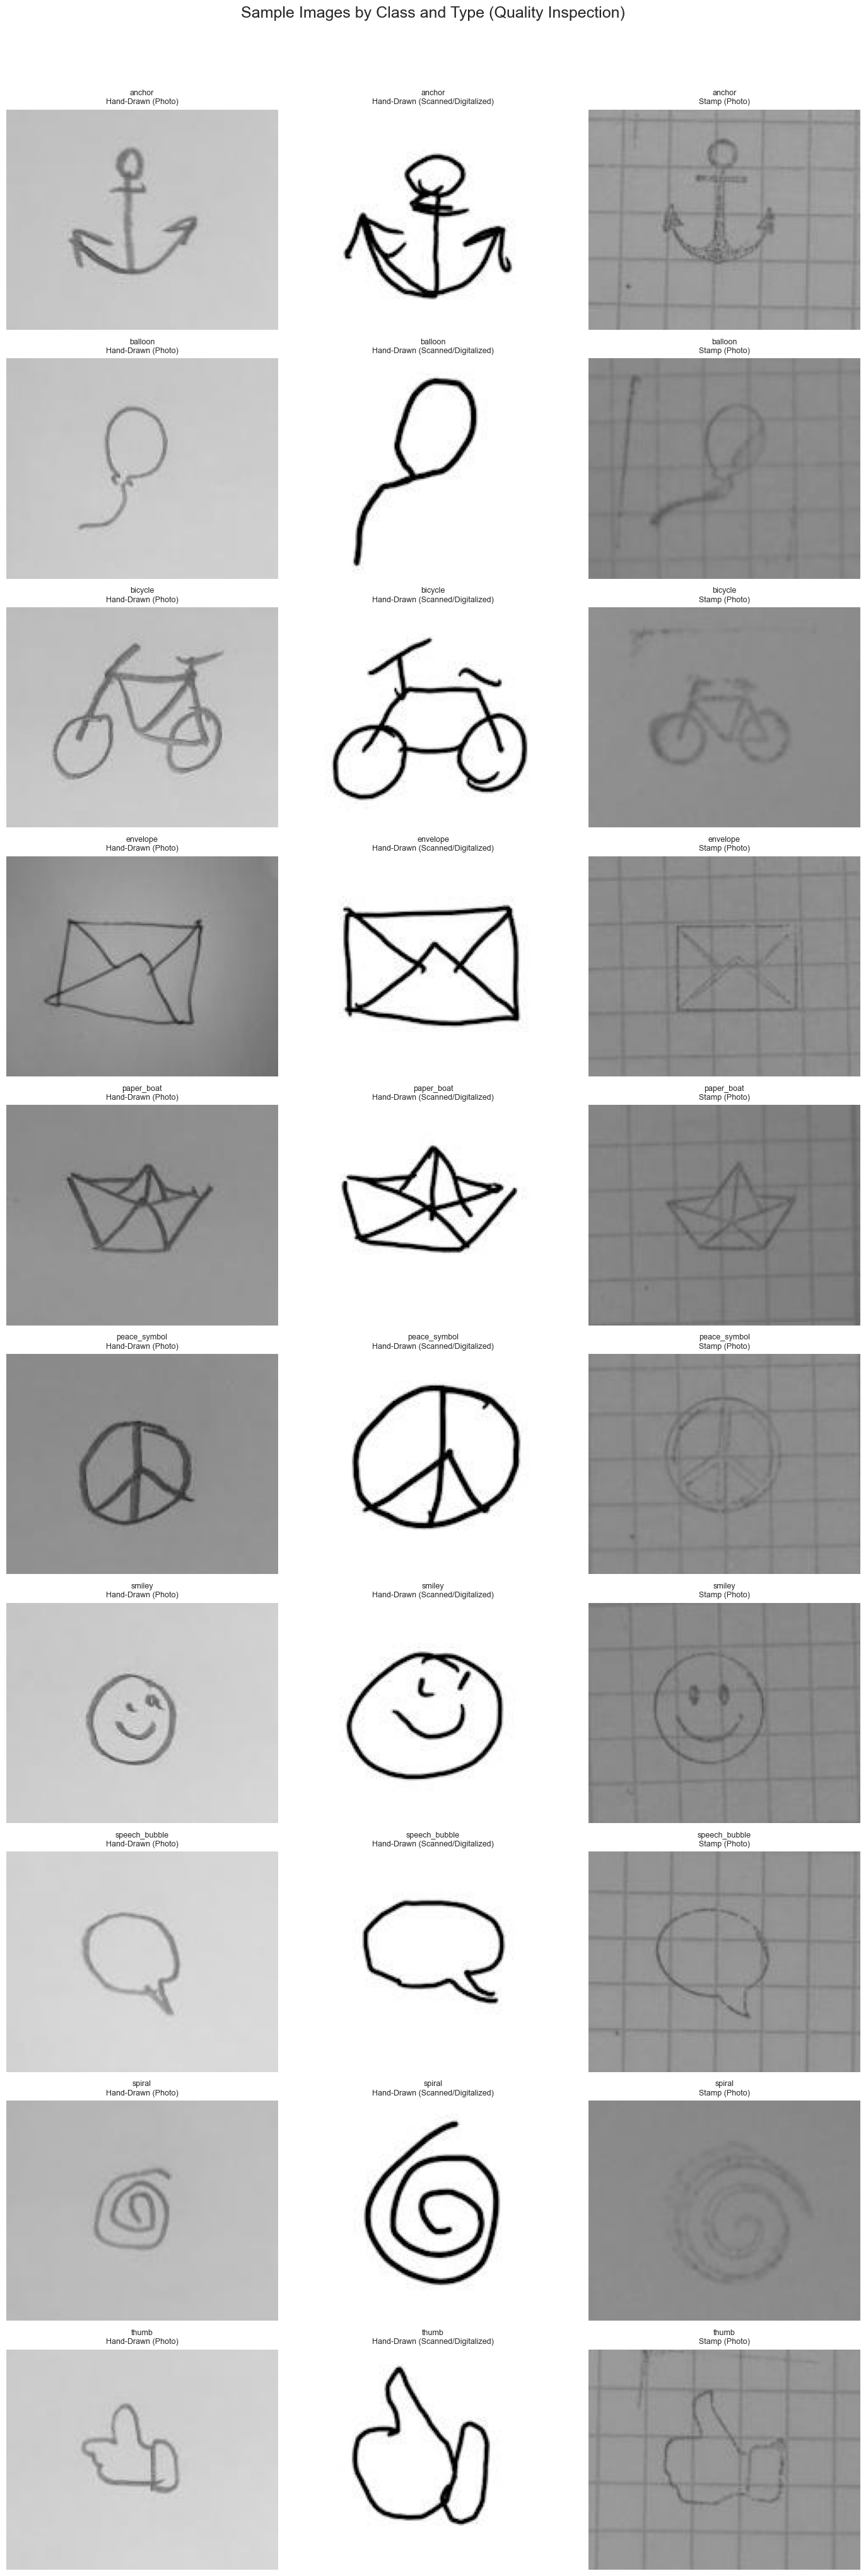

In [78]:
# Sample visualization
classes = data_df["class_name"].unique()
fig, axes = plt.subplots(len(classes), 3, figsize=(14, 4 * len(classes)))
plt.suptitle("Sample Images by Class and Type (Quality Inspection)", y=1.02, fontsize=18)

for i, class_name in enumerate(classes):
    class_data = data_df[data_df["class_name"] == class_name]

    for j, img_type in enumerate(["Hand-Drawn (Photo)", "Hand-Drawn (Scanned/Digitalized)", "Stamp (Photo)"]):
        sample = class_data[class_data["image_type"] == img_type].head(1)

        if not sample.empty:
            filepath = sample["filepath"].iloc[0]
            img = Image.open(filepath).convert("RGB")
            axes[i,j].imshow(img)
            axes[i,j].set_title(f"{class_name}\n{img_type}", fontsize=9)
        else:
            axes[i,j].set_title(f"No samples: {img_type}", fontsize=9)

        axes[i,j].axis("off")

plt.tight_layout()
plt.show()

In [82]:
# Using train_test_split with stratification to maintain class blance in subset
TEST_SIZE = 0.15 # 15% for the Test set
VAL_SIZE = 0.15  # 15% for the Validation set

# 1. Split off the test set (TEST)
train_val_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=42, stratify=data_df["class_name"])

# 2. Split remaining data into training (TRAIN) and validation (VAL) sets
# Calculate validation set proportion relative to the new smaller set (train_val_df)
val_relative_size = VAL_SIZE / (1 - TEST_SIZE)

train_df, val_df = train_test_split(train_val_df, test_size=val_relative_size, random_state=42, stratify=train_val_df["class_name"])

print("DATA SPLIT INTO SETS (STRATIFIED):")
print(f"Training Set (TRAIN): {len(train_df)} images")
print(f"Validation Set (VAL): {len(val_df)} images")
print(f"Test Set (TEST) LOCKED: {len(test_df)} images")

DATA SPLIT INTO SETS (STRATIFIED):
Training Set (TRAIN): 301 images
Validation Set (VAL): 65 images
Test Set (TEST) LOCKED: 65 images
